# LLE calculation for fluid mixtures with SAFT-$\gamma$-Mie

In this notebook, LLE calculations with ```saftgammamie``` EoS are illustrated.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays.
- matplotlib: to plot results.
- ternary: plot ternary plots in python.
- sgtpy: package with SAFT-$\gamma$-Mie EoS and phase equilibria functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ternary
from sgtpy import component, mixture, saftgammamie
from sgtpy.equilibrium import flash

Now, pure components are configured and created with the ```component``` function. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook, all calculations are exemplified for a mixture of butanol, water and hexane.

In [2]:
hexane = component(GC={'CH3':2, 'CH2':4})
butanol = component(GC={'CH3':1, 'CH2':2, 'CH2OH':1})
water = component(GC={'H2O':1})

# creating mixture with mixture class function
mix = mixture(butanol, water)
mix.add_component(hexane)
# or creating mixture by adding pure components
mix = butanol + water + hexane

mix.saftgammamie()
eos = saftgammamie(mix)

## LLE calculation

This type of equilibria calculation is carried out at given global composition (z), temperature (K), and pressure (Pa). This calculation can be performed with ```flash``` or ```lle``` function.

The flash calculation is carried out with the ```flash``` function and it requires initial guesses for the phase composition ```x0```, ```w0``` and their aggregation state (```LL``` for liquid/liquid equilibria).

The ```lle``` requires initial guesses for the phase composition ```x0``` and ```w0```.

The ```full_output``` option allows obtaining all the information related to the LLE calculation. This includes the volume of the phases and the solution for the fraction of the nonbonded sites of each phase.

In [3]:
from sgtpy.equilibrium import lle
# phase equilibria conditions
T = 305.  # K
P = 1.01325e5  # Pa
z = np.array([0.3, 0.6, 0.1])
# initial guesses
x0 = np.array([0.5, 0.2, 0.3])
w0 = np.array([0.05, 0.9, 0.05])
lle(x0, w0, z, T, P, eos, full_output=True)

           T: 305.0
           P: 101325.0
 error_outer: 4.016069160084436e-09
 error_inner: 1.3957597284428247e-10
        iter: 16
        beta: array([0.5332286, 0.4667714])
       tetha: array([0.])
           X: array([[5.39298019e-01, 2.73172481e-01, 1.87529500e-01],
       [2.66316036e-02, 9.73360026e-01, 8.37026712e-06]])
           v: [7.708480480978561e-05, 1.9802453106964483e-05]
        Xass: [array([0.17625428, 0.28502052, 0.04767935, 0.64607345]), array([0.60830898, 0.0382345 , 0.06855701, 0.08951296])]
      states: ['L', 'L']
      method: 'ASS'

## Ternary diagram at constant pressure and temperature

To compute a ternary LLE diagram it is recommended to compute LLE for the binary subsystems first. 

Then, depending on the diagram type (with or without a critical point), you can generate a global composition path to compute the LLE.

In [4]:
n = 100 
X = np.zeros([3, n])
W = np.zeros([3, n])
vx = np.zeros(n)
vw = np.zeros(n)

# LLE for butanol - water subsystem
i = 0
z1 = np.array([0.3, 0.7, 0.])
x1 = np.array([0.4, 0.6, 0.])
w1 = np.array([0.15, 0.85, 0.])
sol = lle(x1, w1, z1, T, P, eos, full_output=True)
X[:, i], W[:, i] = sol.X
vx[i], vw[i] = sol.v
sol

           T: 305.0
           P: 101325.0
 error_outer: 9.353940719860591e-09
 error_inner: 2.2036325758143545e-09
        iter: 16
        beta: array([0.6469327, 0.3530673])
       tetha: array([0.])
           X: array([[0.4462296 , 0.5537704 , 0.        ],
       [0.03206041, 0.96793959, 0.        ]])
           v: [4.937781305097238e-05, 2.015832000885507e-05]
        Xass: [array([0.21053824, 0.15515324, 0.04141608, 0.4041206 ]), array([0.59663667, 0.03939195, 0.06751166, 0.09264907])]
      states: ['L', 'L']
      method: 'ASS'

In [5]:
# LLE for water-hexane subsystem
i = n-1
z0 = np.array([0.0, 0.5, 0.5])
x0 = np.array([0.0, 0.0, 1.0])
w0 = np.array([0.0, 1.0, 0.0])

sol = lle(x0, w0, z0, T, P, eos, full_output=True)
X[:, i], W[:, i] = sol.X
vx[i], vw[i] = sol.v
sol

           T: 305.0
           P: 101325.0
 error_outer: 2.8875545574911935e-09
 error_inner: 1.0000003766806058e-10
        iter: 3
        beta: array([0.50021494, 0.49978506])
       tetha: array([0.])
           X: array([[0.00000000e+00, 4.31805801e-04, 9.99568194e-01],
       [0.00000000e+00, 9.99997887e-01, 2.11253246e-06]])
           v: [0.00013231866712327974, 1.8069746984208134e-05]
        Xass: [array([0.99966754, 0.98030549, 0.99163676, 0.99163676]), array([0.67083419, 0.03263571, 0.0746083 , 0.0746083 ])]
      states: ['L', 'L']
      method: 'ASS'

In [6]:
# generating global composition path
i = 0
z0 = (X[:, i] + W[:, i])/2
i = -1
z1 = (X[:, i] + W[:, i])/2
Zs = np.linspace(z0, z1, n)

# computing LLE using previous computed compositions and volumes as initial guesses
for i in range(1, n-1):
    sol = lle(X[:, i-1], W[:, i-1], Zs[i], T, P, eos, v0=[vx[i-1], vw[i-1]], full_output=True)
    X[:, i], W[:, i] = sol.X
    vx[i], vw[i] = sol.v
    # print(i, sol.error_outer, sol.error_inner, sol.tetha, sol.iter)

The results are plotted bellow.

(-0.05, 1.05, -0.1, 0.9)

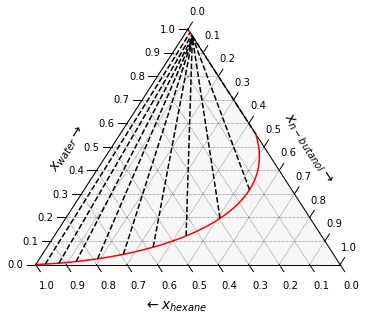

In [7]:
fig = plt.figure(figsize = (6,5))

fontsize = 14
ax3 = fig.add_subplot(111)
tax = ternary.TernaryAxesSubplot(ax=ax3, scale = 1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(color="black", multiple=0.1, linewidth=0.5)

tax.plot(X.T, color = "r")
tax.plot(W.T, color = "r")
# tax.plot(Zs, color = "b")

for i in range(0, n, 10):
    tax.plot([X[:, i], W[:, i]], linestyle='--', color='k')

tax.ticks(clockwise=True, multiple=0.1, linewidth=1, offset = 0.03,tick_formats='%.1f')


#Set labels
tax.right_axis_label(r"$x_{n-butanol}\rightarrow$", fontsize=fontsize, offset = 0.15)
tax.left_axis_label(r"$x_{water} \rightarrow$", fontsize=fontsize, offset = 0.15)
tax.bottom_axis_label(r"$\leftarrow x_{hexane}$", fontsize=fontsize, offset = 0.15)


# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax._redraw_labels()
ternary.plt.axis('off')
#fig.savefig('lle-ternary.pdf')

For further information of any of these functions just run: ```function?```